In [24]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(".."))

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    f1_score,
    RocCurveDisplay
)

# settings
pd.set_option("display.max_columns", None)

In [25]:
df = pd.read_csv("../data/sanctions_features.csv")
df.head()

,ent_num,cleaned_name,fuzz_ratio_reference,name_length,word_count,has_country_in_name,fuzz_ratio,length_diff,common_token_count
0,36,AEROCARIBBEAN AIRLINES,AIRLINES,22,2,0,53.33,14,1
1,173,ANGLO CARIBBEAN CO LTD,AIRLINES,22,4,0,26.67,14,0
2,306,BANCO NACIONAL DE CUBA,AIRLINES,22,4,0,20.00,14,0
3,306,BANCO NACIONAL DE CUBA,AIRLINES,22,4,0,20.00,14,0
4,306,BANCO NACIONAL DE CUBA,AIRLINES,22,4,0,20.00,14,0


In [26]:
# TEMPORARY: For testing, label 1 for top 5 fuzzy matches
df['is_match'] = (df['fuzz_ratio'] > 75).astype(int)

In [27]:
# Prepare train/test split
X = df.drop(columns=["is_match", "cleaned_name", "fuzz_ratio_reference"])
y = df["is_match"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [29]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)

c:\xampp\htdocs\data-engineering\ofac-end-to-end-data-project\sanction-risk-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:16:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
# Evaluate Performance
def evaluate_model(model, name):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    print(f"Results for {name}")
    print(classification_report(y_test, preds, digits=3))
    print(f"AUC-ROC: {roc_auc_score(y_test, probs):.3f}")
    print("-" * 40)

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {name}")
    plt.show()

Results for Logistic Regression
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9865
           1      1.000     1.000     1.000         3

    accuracy                          1.000      9868
   macro avg      1.000     1.000     1.000      9868
weighted avg      1.000     1.000     1.000      9868

AUC-ROC: 1.000
----------------------------------------


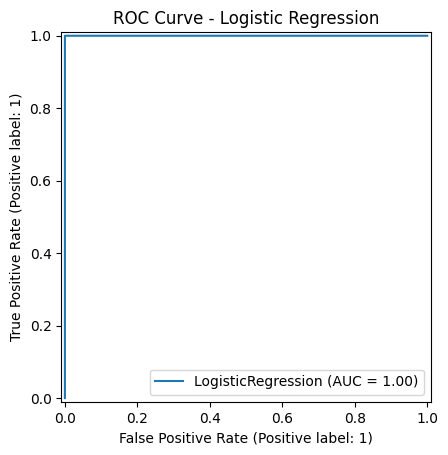

Results for Random Forest
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9865
           1      1.000     0.667     0.800         3

    accuracy                          1.000      9868
   macro avg      1.000     0.833     0.900      9868
weighted avg      1.000     1.000     1.000      9868

AUC-ROC: 1.000
----------------------------------------


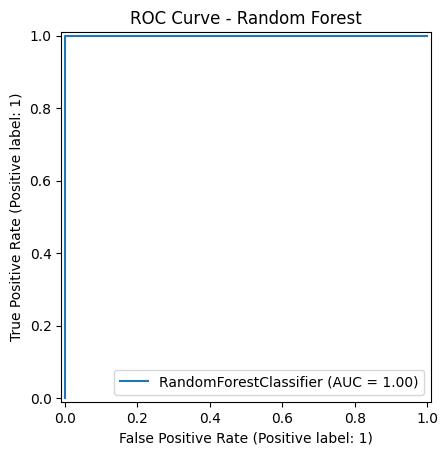

Results for XGBoost
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9865
           1      1.000     0.667     0.800         3

    accuracy                          1.000      9868
   macro avg      1.000     0.833     0.900      9868
weighted avg      1.000     1.000     1.000      9868

AUC-ROC: 1.000
----------------------------------------


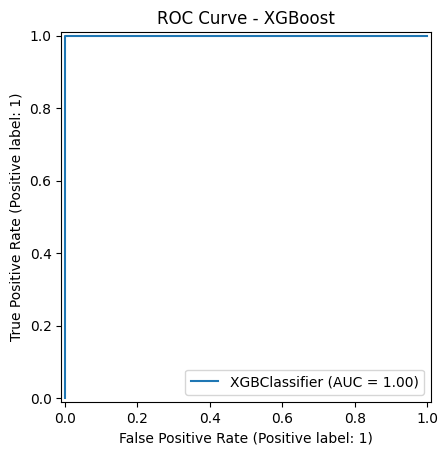

In [32]:
evaluate_model(lr, "Logistic Regression")
evaluate_model(rf, "Random Forest")
evaluate_model(xgb, "XGBoost")
